In [1]:
# Forward-mode (dual numbers)
class dual:
    def __init__(self, primal, dual=0):
        self.primal = primal
        self.dual = dual

    def __add__(self, other):
        return dual(
            self.primal + other.primal,
            self.dual + other.dual
        )

    def __mul__(self, other):
        return dual(
            self.primal * other.primal,
            other.primal * self.dual + other.dual * self.primal
        )

    def __str__(self):
        return '(%f + %fϵ)' % (self.primal, self.dual)

In [2]:
a = dual(2., 1.)
b = dual(3., 0.)
c = dual(5., 0.)
out = a * a * a + b * c
print(out)

(23.000000 + 12.000000ϵ)


In [3]:
# Reverse-mode (graph-style with reference counting)
class node:
    def __init__(self):
        self.refs = 0.
    
    def used(self):
        self.refs += 1
        return self
    
    def done(self):
        self.refs -= 1

    def __add__(self, other):
        return sum_node(self, other)
    
    def __mul__(self, other):
        return product_node(self, other)

    def __str__(self):
        return '%s [grad = %s]' % (str(self.value), str(self.grad))
    
    def detach(self):
        return var_node(value=self.value)

class var_node(node):
    def __init__(self, value):
        super().__init__()
        self.value = value
        self.grad = dual(0.)

    def backwards(self, root=False):
        if root:
            self.grad = dual(1.)
        pass

class sum_node(node):
    def __init__(self, L, R):
        super().__init__()
        self.L = L.used()
        self.R = R.used()
        self.value = L.value + R.value
        self.grad = dual(0.)

    def backwards(self, root=False):
        if self.refs > 0:
            return
        if root:
            self.grad = dual(1.)
        self.L.grad += self.grad
        self.R.grad += self.grad
        self.L.done()
        self.L.backwards()
        self.R.done()
        self.R.backwards()

class product_node(node):
    def __init__(self, L, R):
        super().__init__()
        self.L = L.used()
        self.R = R.used()
        self.value = L.value * R.value
        self.grad = dual(0.)

    def backwards(self, root=False):
        if self.refs > 0:
            return
        if root:
            self.grad = dual(1.)
        self.L.grad += self.R.value * self.grad
        self.R.grad += self.L.value * self.grad
        self.L.done()
        self.L.backwards()
        self.R.done()
        self.R.backwards()

In [4]:
a = var_node(dual(2.))
b = var_node(dual(3.))
c = var_node(dual(5.))
out = a * a * a + b * c

out.backwards(True)
assert a.grad.primal == 12.
assert b.grad.primal == 5
assert c.grad.primal == 3
print(a)
print(b)
print(c)

(2.000000 + 0.000000ϵ) [grad = (12.000000 + 0.000000ϵ)]
(3.000000 + 0.000000ϵ) [grad = (5.000000 + 0.000000ϵ)]
(5.000000 + 0.000000ϵ) [grad = (3.000000 + 0.000000ϵ)]


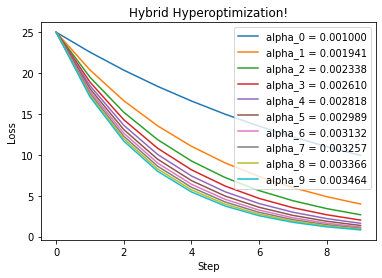

In [5]:
# Nested gradient descent
from matplotlib import pyplot as plt

kappa = dual(-0.0000001)
alpha = dual(0.001, 1.) # notice, we set eps=1 here!

def get_loss(a):
    # as an example, we want to minimize (5a - 10)^2
    delta = a * var_node(dual(5.)) + var_node(dual(-10.))
    return delta * delta

# this loop optimizes "alpha"
for outer in range(10):
    a = var_node(dual(1.))
    graph = []
    
    # this loop optimizes "a"
    for inner in range(10):
        loss = get_loss(a)
        loss.backwards(True)
        
        # update rule for "a" in "reverse-mode" API
        a = a + var_node(alpha) * var_node(a.grad) * var_node(dual(-1.))
        a = a.detach()  # :)
        graph.append(loss.value.primal)

    plt.plot(graph, label='alpha_%d = %05f' % (outer, alpha.primal))
    
    # update rule for "alpha" in "forward-mode" API
    alpha = alpha + dual(loss.value.dual) * kappa

plt.title('Hybrid Hyperoptimization!')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()